# Missing Data

Missing data are a fact of life.  A malfunctioning instrument, an unanswered question on a survey, a processing mistake.  We expect that our data are imperfect, messy, and occassionally entirely absent.  Depending on your field of study, you may find that the majority of your time is take up with data cleaning.  Indeed, [some surveys](https://www.anaconda.com/resources/whitepapers/state-of-data-science-2020) of data scientists suggest up to 50% of their time is take up with data management of some form.  And, this includes dealing with missing data.  

Why are we worried about missing data?  As climate and atmospheric scientist Tapio Schneider [writes](https://doi.org/10.1175/1520-0442(2001)014<0853:AOICDE>2.0.CO;2):

> Because the availability of climatic measurements varies spatially and temporally, sets of climate data are usually incomplete. This circumstance complicates multivariate analyses of climate data. Already the estimation of mean values and covariance matrices, the funda- mental statistics from which every multivariate analysis issues, becomes difficult when a dataset is incomplete.

Of course, this isn't an issue limited to climate science.  One of the class papers about missing and incomplete data, Rubin [writes](https://doi.org/10.1093/biomet/63.3.581):

> The problem of missing data arises frequently in practice. For example, consider a large survey of families conducted in 1967 with many socioeconomic variables recorded, and a follow-up survey of the same families in 1970. Not only is it likely that there will be a few missing values scattered throughout the data set, but also it is likely that there will be a large block of missing values in the 1970 data because many families studied in 1967 could not be located in 1970.

Incomplete datasets from whatever field and for whatever cause are a barrier to statistical analysis of these data.   This is particularly true for some of the types of analyses that interest us most in this class.  Schneider [continues]((https://doi.org/10.1175/1520-0442(2001)014<0853:AOICDE>2.0.CO;2)):

> For instance, the sample mean of the available data can be an inaccurate estimate of the mean of the data. And if one would estimate a covariance matrix from all data available in an incomplete dataset, leaving out in the sample covariance matrix the terms involving missing values, the estimated covariance matrix would not necessarily be positive semide- finite and might have negative eigenvalues. But a covariance matrix estimate with negative eigenvalues might lead to erratic results in analyses that, like the principal component analysis, rest upon eigendecompositions of covariance matrices. Moreover, projections of multivariate data onto subspaces—projections onto the empirical orthogonal functions (EOFs) of a principal component analysis, for example—are not well-defined when values of variables are missing.





There is no single solution to the existence of missing data.  Below we will look at some solutions -- ranging from the simplest to more complex approaches -- that allow us to make what we hope are reasonable accommodations or estimates for the missing values in our data.  Ultimately, however, what we need to be most aware of is how the presence of missing data _and_ our solution for dealing with it affect the inferences we make from those incomplete data.  An inference that is relatively robust to the assumptions and decisions we make is stronger than one where the inference is sensitive to these weakly-constrained choices.  

Let's first import our packages and libraries as usual:

In [209]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

To start, let us create a simple Numpy array on which we can practice some simple solutions (and see the effects of our choices):

In [210]:
d = np.array([[ 0,  1,  2,  3], [ 4,  5,  6,  7], [ 8,  9, 10, 11]],dtype=float) # set dtype to float to allow us to set NaN by index, since NaN is considered a float type
d

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.]])

We'll save the 'true' mean and covariance first, before we artificially remove data for these examples:

In [211]:
true_cov = np.cov(d,rowvar=False,ddof=1)
true_mean = np.mean(d,axis=0)

Let's remove just two values - one in each of two columns (here using NaN to stand in for the absent data):

In [212]:
d0 = d.copy()
d[1,1] = np.nan # remove 5
d[2,2] = np.nan # remove 10
d

array([[ 0.,  1.,  2.,  3.],
       [ 4., nan,  6.,  7.],
       [ 8.,  9., nan, 11.]])

Let us then put this array into a [Pandas dataframe, to allow us to use that library's functions for handling missing data](https://pandas.pydata.org/docs/user_guide/missing_data.html). 

In [213]:
df0 = pd.DataFrame(d0, columns = ['Column_A','Column_B','Column_C','Column_D']) # no missing data in dataframe
df = pd.DataFrame(d, columns = ['Column_A','Column_B','Column_C','Column_D']) # missing data in dataframe
df

,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,NaN,6.0,7.0
2,8.0,9.0,NaN,11.0


### Deletion

The simplest of all approaches is to delete or remove from consideration the missing data.  For us in this class, this often means some location (variable) where some but not all of the observations of that variable at that location are absent.  We already saw an example of this on Homework #2, where we decided to work only with those locations with complete records of sea surface temperature.  In that case, the 'missing' data was due to the presense of sea ice.  It was simplest to delete those relatively few grid locations and work with a complete data matrix. 

In the simple matrix above, where we have much fewer variables and observations. Let's see how to use Panda's `.dropna()`.  First, let's just use the defaults - applying `.dropna()` drops any row that has a NaN, leaving us with just the 0th row. 

In [214]:
df.dropna()

,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0


Alternatively, dropping columns with any NaN value leaves us with Column A and D only:

In [215]:
df.dropna(axis='columns')


,Column_A,Column_D
0,0.0,3.0
1,4.0,7.0
2,8.0,11.0


Conversely, specifying `'all'` means to drop those rows which are entirely fill of NaN values:

In [216]:
df.dropna(how='all')

,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,NaN,6.0,7.0
2,8.0,9.0,NaN,11.0


If we wished to simply use Boolean values to index where the NaNs are, or are not, we can use `.isna()` or `.notna`

In [217]:
print(df.isna())
print(df.notna())

   Column_A  Column_B  Column_C  Column_D
0     False     False     False     False
1     False      True     False     False
2     False     False      True     False
   Column_A  Column_B  Column_C  Column_D
0      True      True      True      True
1      True     False      True      True
2      True      True     False      True


Can we calculate a covariance matrix then using Panda's functionality for handling missing data.  First, what would we expect from the dataframe with no missing data? 

In [242]:
df0.cov(ddof=1)

,Column_A,Column_B,Column_C,Column_D
Column_A,16.0,16.0,16.0,16.0
Column_B,16.0,16.0,16.0,16.0
Column_C,16.0,16.0,16.0,16.0
Column_D,16.0,16.0,16.0,16.0


Next, what does the covariance matrix look like when there are missing data in Column B and Column C? 

In [251]:
df.cov(ddof=1)


,Column_A,Column_B,Column_C,Column_D
Column_A,16.0,32.0,8.0,16.0
Column_B,32.0,32.0,NaN,32.0
Column_C,8.0,NaN,8.0,8.0
Column_D,16.0,32.0,8.0,16.0


Huh!  A few observations - the variance in Column B increased by double but decreased by half in Column C.  [Make sure you understand why mathematically, but also note this perhaps unexpected behavior](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cov.html) - Panda's variance calculation doesn't return a NaN for the entire column (try it: `dr.var(ddof=1,axis=0)`).  The loss of just 2 data points also reverberated in other covariance calculations where either column was involved, but again  But finally, the covariance of a column with another column with a NaN is a NaN.   This is peculiar behavior to me - one might expect that any calculations with NaN would return a NaN or that none would, leaving the mix of outcomes here odd (again, at least to me).  

A couple words of caution then:  Python uses both `None` and `NaN` ([and `NA`, sorta](https://pandas.pydata.org/docs/user_guide/missing_data.html#missing-data-na)) to indicate missing data.  But these different ways of indicating the same thing have (of course!) different properties.  One of these is that `NaN` doesn't respond to comparisions like equalities as you might expect: 

In [219]:
np.nan == np.nan

False

Applying that unfortunate characteristic to our simple dataframe above:

In [220]:
df["Column_B"] == np.nan

0    False
1    False
2    False
Name: Column_B, dtype: bool

Ack.  So no using `NaN` if you need or want to use comparisons such as equalities.  `None` behaves like you think it might:

In [221]:
None == None

True

`NaN` is also considered a float, so when we created an array above, even though it contained integers we had to force it to be a float type to accomodate `NaN` values. 


Numpy has some similar features as Pandas for identifying NaN values.  It supplies `np.isnan` which returns a Boolean array of the same size as the data array, with True anywhere there is a NaN value.  negating the Numpy statement with `~` returns the opposite (essentially, 'tell me where values are NOT NaNs'), and so returning False where values are NaN. 



In [222]:
print(np.isnan(d))
print(~np.isnan(d))

[[False False False False]
 [False  True False False]
 [False False  True False]]
[[ True  True  True  True]
 [ True False  True  True]
 [ True  True False  True]]


Alternatively, combining `np.isnan()` with `np.argwhere` returns the coordinate (row, column) where the NaN values are located:

In [223]:
np.argwhere(np.isnan(d))


array([[1, 1],
       [2, 2]])


In general, be cautious with missing values.  Once again, Python deals with these inconsistently, even within a package!  I encourage you to take the time to familiarize yourself with the basics of missing value handing in the various different libraries we use in class, and always deploy your 'sanity checks' on any data you've handled when dealing with NaNs.

### Imputation

Instead of deleting, ignoring, or dropping NaN values, we might seek to replace them with an estimate of the missing value, which we call **imputation**.   The most basic imputations use the mean, median, or mode of the data.  In Numpy, you can do this using `np.nan_to_num`:

In [224]:
# Mean imputation in Numpy
print(np.nan_to_num(d, nan=np.nanmean(d,axis=0)))

[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9.  4. 11.]]


In Pandas, you can use the `.fillna` method and specify the mean of the column:

In [225]:
# Mean imputation in Pandas
df.fillna(df.mean(axis=0))


,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,5.0,6.0,7.0
2,8.0,9.0,4.0,11.0


Similarly, we could fill missing values with the median:

In [226]:
# Median imputation
print(np.nan_to_num(d, nan=np.nanmedian(d,axis=0)))
df.fillna(df.median(axis=0))


[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9.  4. 11.]]


,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,5.0,6.0,7.0
2,8.0,9.0,4.0,11.0


Especially if several values in a row are missing, we might instead us an **interpolation**.  Interpolation in general allows us to estimate values at locations between sampling locations.  Missing values can be seen in this light.  We actually have several 'flavors' or techniques we can use for interpolation.  [Pandas provides a range of options for interpolation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html).  A common approach is a linear interpolation: 

In [227]:
# Linear interpolation in Pandas 
df_imputed_linear = df.interpolate(method='linear')
df_imputed_linear


,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,5.0,6.0,7.0
2,8.0,9.0,6.0,11.0


We can use `.interpolate` with other methods, like nearest neighbor:

In [228]:
# Nearest neighbor interpolation in Pandas 
df_imputed_nearest = df.interpolate(method='nearest')
df_imputed_nearest

,Column_A,Column_B,Column_C,Column_D
0,0.0,1.0,2.0,3.0
1,4.0,1.0,6.0,7.0
2,8.0,9.0,NaN,11.0


A package we haven't used yet -- scikit-learn -- contains a range of ways of doin interpolation.  You can see more about these methods here for [imputation](https://scikit-learn.org/stable/modules/impute.html) generally, and for the iterative imputation capabilities in the [IterativeImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html). The Simple Imputation in scikit-learn is similar to Pandas approaches to replacing missing values with alternatives (mean, median, etc).  The IterativeImputer however has the capacity to do vrious ensemble-based, iterative approaches that can potentially incorporate a greater amount of information in imputing missing values.  These features are still 'experimental' so we have to load the library with the following set of commands:

In [229]:
# Tell scikit-learn to allow us to use this experimental feature
from sklearn.experimental import enable_iterative_imputer  
# import normally from sklearn.impute
from sklearn.impute import IterativeImputer
 
# define the imputer
imputer = IterativeImputer(random_state=0)

# impute missing values using regression
df_imputed_regression = imputer.fit_transform(df)
df_imputed_regression

array([[ 0.        ,  1.        ,  2.        ,  3.        ],
       [ 4.        ,  5.00050768,  6.        ,  7.        ],
       [ 8.        ,  9.        ,  9.99966003, 11.        ]])

You can see that this approach did a much better job at the missing value in Column C than other imputation and interpolation methods. 

Interpolation is also available in xarray and operates similarly to Pandas.  Here are some resources to review:

* [Missing values in xarray computations](https://docs.xarray.dev/en/stable/user-guide/computation.html#missing-values)
* [Overall interpolation in xarray](https://docs.xarray.dev/en/stable/user-guide/interpolation.html)
* [Interpolation for missing values in xarray](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html)


## Applications to real data

### Cereal data from the FAO

Here we're going to use some imputation methods applied to our cereal data from Homework #2.  While I had you specifically selection only those countries with complete data over the full span of time, we might want to loosen this requirement and estimate missing values for some countries to be able to include them in our analysis.  

First, let's read in our cereal data and then look at the percent of missing data per country:

Text(0, 0.5, 'Frequency (number of countries)')

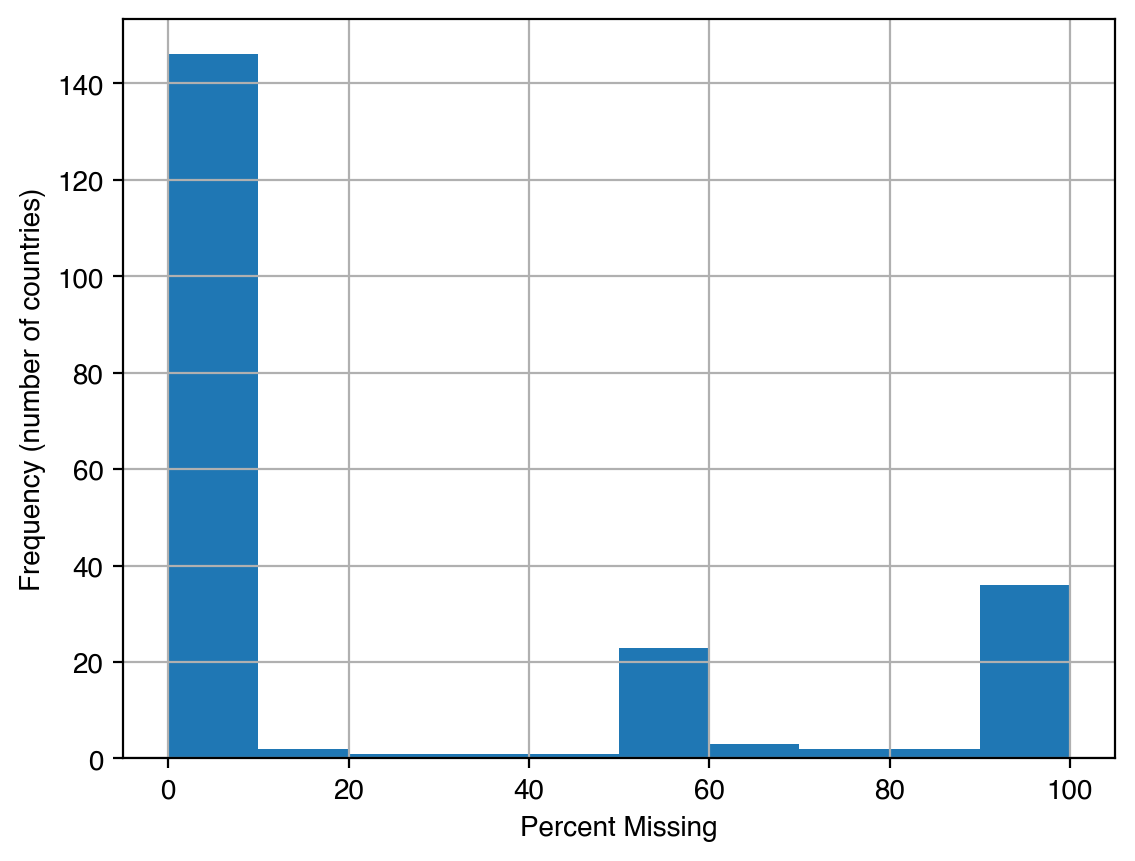

In [312]:
pd.set_option('display.max_rows', 61)


df = pd.read_excel('cereal_production_WB_FAO_2022.xlsx',index_col=[0])
df

percent_missing = 100 * df.isnull().sum()/df.shape[0]
percent_missing.hist()
plt.xlabel("Percent Missing")
plt.ylabel("Frequency (number of countries)")


We can see that most countries have complete data, a few have a few missing years of data, a number are missing perhaps half or more, and some are entirely lacking data. We can look at this in terms of years as well:

Text(0, 0.5, 'Frequency (number of countries)')

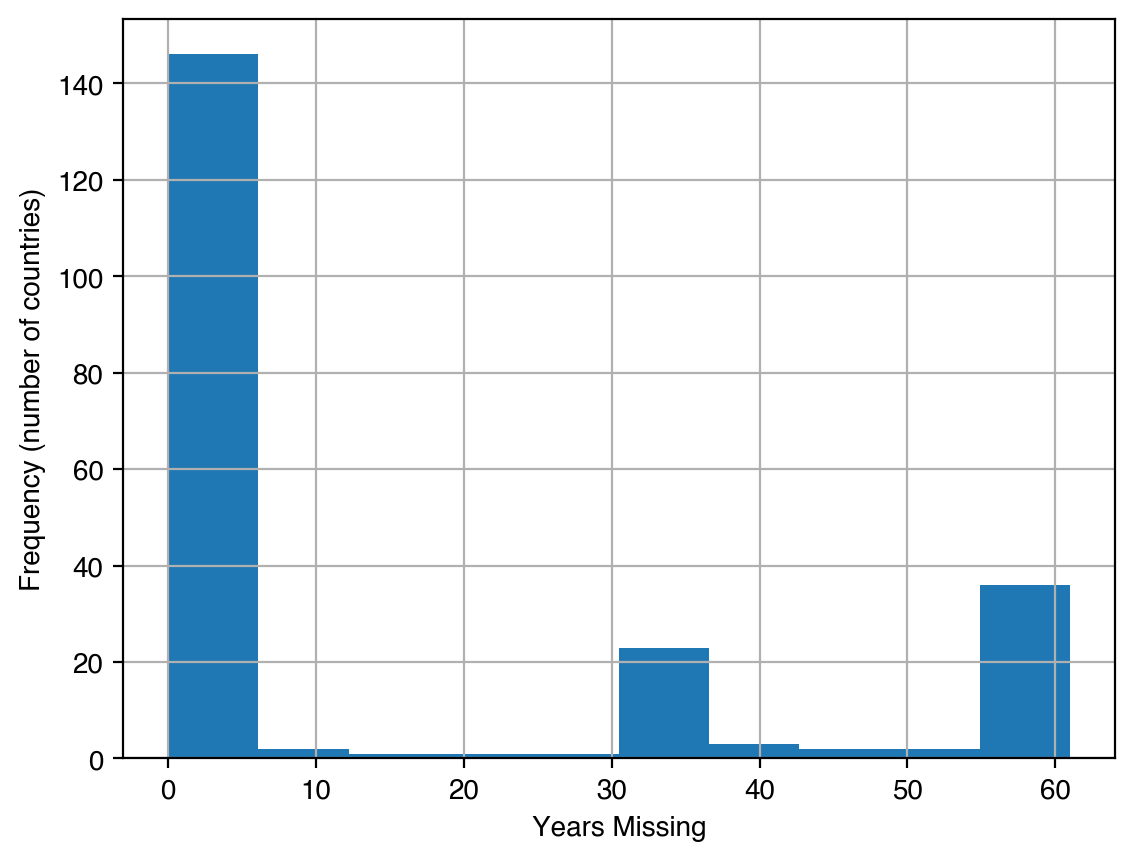

In [313]:

years_missing = df.isnull().sum()
years_missing.hist()
plt.xlabel("Years Missing")
plt.ylabel("Frequency (number of countries)")


Based on this, we might set a more liberal threshold for missing data.  We might decide to try and capture the few countries with between 1 and 30 years missing:

In [315]:
missingness_threshold = 30
below_threshold = df.isnull().sum() < 30 # gives us 150 vs. 145 if we accept no missing data


# pull out countries without missing data and put them in a new DataFrame
cereals = df.loc[:,below_threshold].copy()
years = df.index.values.tolist()

incomplete_countries = cereals.isna().any()

cereals.loc[:,cereals.isna().any()]

,Antigua and Barbuda [ATG],Djibouti [DJI],Kuwait [KWT],Qatar [QAT],United Arab Emirates [ARE]
Time,,,,,
1961,NaN,NaN,NaN,NaN,NaN
1962,NaN,NaN,NaN,NaN,NaN
1963,NaN,NaN,NaN,NaN,NaN
1964,NaN,NaN,NaN,NaN,NaN
1965,NaN,NaN,NaN,NaN,NaN
1966,30.00,NaN,NaN,NaN,NaN
1967,18.00,NaN,NaN,NaN,NaN
1968,30.00,NaN,3.00,NaN,NaN
1969,45.00,NaN,5.00,NaN,NaN


We can see that most of these countries are missing consecutive years early in the record.  At this point we might decide that we did the right thing - it would be difficult to confidently impute those data with most of the methods we've seen.  But, let's try a few.  First, let's see what `.interpolate` does.  Since we are missing values early in the record, a linear interpolation is unlikely to work, but we can try a few other methods:

In [328]:
# Backfill interpolation in Pandas 
cereals_imputed_Backfill = cereals.interpolate(method='bfill') # same as bfill command from .fillna
cereals_imputed_Backfill.loc[:,incomplete_countries]

,Antigua and Barbuda [ATG],Djibouti [DJI],Kuwait [KWT],Qatar [QAT],United Arab Emirates [ARE]
Time,,,,,
1961,30.00,5.00,3.00,161.00,14.00
1962,30.00,5.00,3.00,161.00,14.00
1963,30.00,5.00,3.00,161.00,14.00
1964,30.00,5.00,3.00,161.00,14.00
1965,30.00,5.00,3.00,161.00,14.00
1966,30.00,5.00,3.00,161.00,14.00
1967,18.00,5.00,3.00,161.00,14.00
1968,30.00,5.00,3.00,161.00,14.00
1969,45.00,5.00,5.00,161.00,14.00


Without much to work on, the usefulness of interpolation is minimal in this dataset, and the default behavior is largely to in-fill with the most recent value. 

In [341]:
# interpolation in Pandas 
cereals_imputed_linear = cereals.interpolate(method="linear",limit_area="outside", limit_direction="both")
cereals_imputed_linear.loc[:,incomplete_countries]

,Antigua and Barbuda [ATG],Djibouti [DJI],Kuwait [KWT],Qatar [QAT],United Arab Emirates [ARE]
Time,,,,,
1961,30.00,5.00,3.00,161.00,14.00
1962,30.00,5.00,3.00,161.00,14.00
1963,30.00,5.00,3.00,161.00,14.00
1964,30.00,5.00,3.00,161.00,14.00
1965,30.00,5.00,3.00,161.00,14.00
1966,30.00,5.00,3.00,161.00,14.00
1967,18.00,5.00,3.00,161.00,14.00
1968,30.00,5.00,3.00,161.00,14.00
1969,45.00,5.00,5.00,161.00,14.00


Let's try the multiple imputation approach:

In [359]:
# define the imputer
imputer = IterativeImputer(min_value=0)

# impute missing values using regression
cereals_imputed_regression = imputer.fit_transform(cereals)

cereals_imputed = pd.DataFrame(cereals_imputed_regression, columns = cereals.columns)
cereals_imputed.loc[:,incomplete_countries]


,Antigua and Barbuda [ATG],Djibouti [DJI],Kuwait [KWT],Qatar [QAT],United Arab Emirates [ARE]
0,0.000000,0.000000,3360.761431,0.00,8736.915201
1,0.000000,0.000000,4978.876097,0.00,11851.346021
2,0.000000,0.000000,7630.893965,0.00,9875.050245
3,3.649339,0.000000,5856.186036,0.00,8826.633653
4,8.011010,0.000000,8301.159142,0.00,6215.380788
5,30.000000,0.000000,5684.422650,0.00,5067.260389
6,18.000000,1.096728,10192.959466,0.00,7722.361836
7,30.000000,0.000000,3.000000,0.00,10374.495999
8,45.000000,0.000000,5.000000,0.00,9194.193658
9,60.000000,0.000000,8.000000,0.00,4913.799534


Hmmm, this doesn't look very convincing, does it?  In my opinion, without additiona information to support our imputation of the earliest years in this record, it would be better to leave these few countries out.  Or, alternatively, alter the length of the analysis you are planning on doing to include some of these countries while sacrificing the number of observations. 

This is to emphasize that there is no blackbox solution - we can impute, estimate, delete, etc. but we have to be mindful of the limitations and consequences of these approaches to missing data.  As I wrote above, and emphasize again here:

>There is no single solution to the existence of missing data ... Ultimately, however, what we need to be most aware of is how the presence of missing data _and_ our solution for dealing with it affect the inferences we make from those incomplete data.  An inference that is relatively robust to the assumptions and decisions we make is stronger than one where the inference is sensitive to these weakly-constrained choices. 

So, go forth with caution and always check the consequences of your methods, parameters, and assumptions for the inferences you draw from your data.